Dividend Events with Close Price Difference:
     stock       Date Ex-Div_Date  Close_Dividends  Close_Ex-Div  Close_Diff
146   AMGN 2023-02-14  2023-05-17       226.289261    213.251633  -13.037628
216   AMGN 2023-03-07  2023-05-17       214.732086    213.251633   -1.480453
721   AMGN 2023-08-01  2023-08-17       219.980301    252.076859   32.096558
1016  AMGN 2023-10-24  2023-11-16       263.799316    259.017731   -4.781586
254    CVS 2023-03-16  2023-04-20        70.104385     68.275818   -1.828568
Test Mean Squared Error: 79.60219


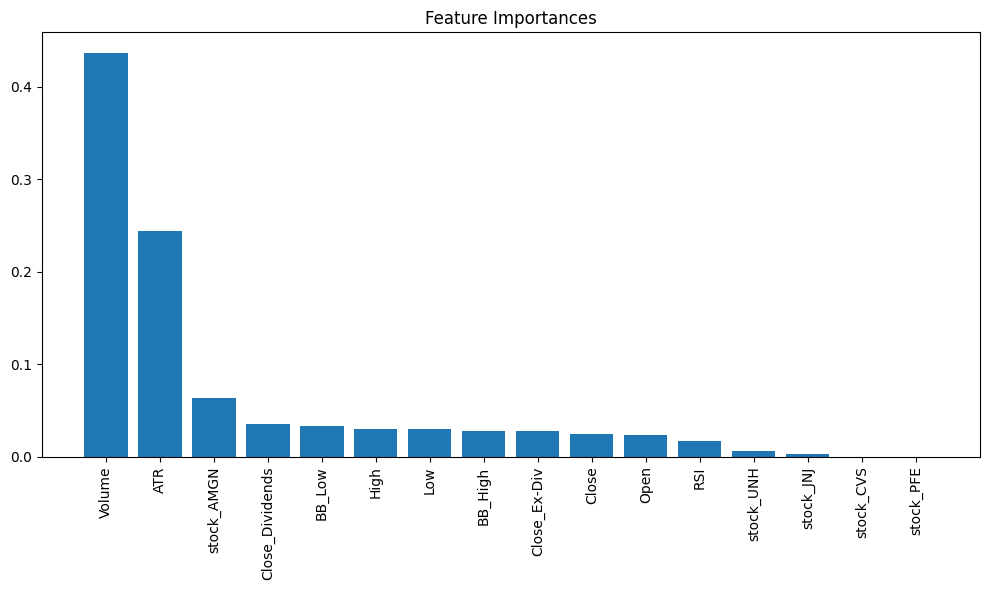

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ----- Step 1: Load and Preprocess the Data -----
# Load the Excel file.
data = pd.read_excel("/content/2023 healthcare stock.xlsx")

# Convert the 'Date' column to datetime if it exists.
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Sort data by Stock and Date (if Stock exists; otherwise just by Date)
if 'stock' in data.columns:
    data.sort_values(['stock', 'Date'], inplace=True)
else:
    data.sort_values('Date', inplace=True)

# ----- Step 2: Pair Declaration and Ex-Div Events to Compute the Target Variable -----
# For each stock, for each declaration event (Dividend != 0), we find the next ex-div event (ExDiv != 0)
# and compute the difference in the "close" price between the two events.
events = []
if 'stock' in data.columns:
    grouped = data.groupby('stock')
else:
    grouped = [('all', data)]

for stock, group in grouped:
    group = group.sort_values('Date')
    # Filter out declaration and ex-div events for the current group
    decl_events = group[group['Dividends'] != 0]
    exdiv_events = group[group['Ex-Div'] != 0]

    for decl_idx, decl_row in decl_events.iterrows():
        # Declaration date and close price
        decl_date = decl_row['Date']
        decl_close = decl_row['Close']

        # Find the first ex-div event for the same stock with a later date than the declaration date
        next_exdiv = exdiv_events[exdiv_events['Date'] > decl_date]
        if not next_exdiv.empty:
            exdiv_row = next_exdiv.iloc[0]
            exdiv_date = exdiv_row['Date']
            exdiv_close = exdiv_row['Close']

            # Compute the difference in close prices (you can also compute percentage change if desired)
            close_diff = exdiv_close - decl_close

            # Create an event record; here we start with the declaration row and add new columns
            event = decl_row.copy()
            event['Ex-Div_Date'] = exdiv_date
            event['Close_Dividends'] = decl_close
            event['Close_Ex-Div'] = exdiv_close
            event['Close_Diff'] = close_diff
            events.append(event)

# Create a DataFrame from the collected events.
df_events = pd.DataFrame(events)

# (Optional) Inspect the events DataFrame
print("Dividend Events with Close Price Difference:")
print(df_events[['stock', 'Date', 'Ex-Div_Date', 'Close_Dividends', 'Close_Ex-Div', 'Close_Diff']].head())

# ----- Step 3: Prepare the Features -----
# Now, the target variable is 'Close_Diff'. We will use features from the declaration row.
# Exclude the dividend-related columns and any date columns from the features.
exclude_cols = ['Close_Diff', 'Dividends', 'Ex-Div', 'Ex-Div_Date', 'Date']
numeric_cols = [col for col in df_events.columns
                if col not in exclude_cols and np.issubdtype(df_events[col].dtype, np.number)]

# Start with numeric features.
X = df_events[numeric_cols].copy()
y = df_events['Close_Diff']

# Optionally, include the stock identifier by one-hot encoding if it exists.
if 'stock' in df_events.columns:
    X = pd.concat([X, pd.get_dummies(df_events['stock'], prefix='stock')], axis=1)

# ----- Step 4: Split the Data and Train the Model -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model performance.
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse:.5f}")

# ----- Step 5: Feature Importance Visualization -----
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X.columns[indices]

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(features_sorted)), importances[indices], align="center")
plt.xticks(range(len(features_sorted)), features_sorted, rotation=90)
plt.tight_layout()
plt.show()

# ----- Step 6: Function to Predict the Best Performing Stock -----
def predict_best_stock(new_data):
    """
    Given a DataFrame new_data with the same feature columns as used in training,
    this function predicts the close price difference (short-term performance) for each dividend event and
    returns the stock with the highest predicted performance.

    Parameters:
      new_data (pd.DataFrame): New input data with feature columns.
         (Ensure that if 'Stock' is a feature, you apply the same encoding as above.)

    Returns:
      best_stock: Identifier of the best performing stock.
      best_predicted_diff: The predicted difference in close price for that stock.
    """
    # If the 'Stock' column is part of the original features, encode it similarly.
    if 'stock' in new_data.columns:
        new_data_encoded = pd.concat([new_data.drop('stock', axis=1),
                                      pd.get_dummies(new_data['stock'], prefix='stock')], axis=1)
        # Align new_data's columns with training features:
        new_data_encoded = new_data_encoded.reindex(columns=X.columns, fill_value=0)
    else:
        new_data_encoded = new_data.reindex(columns=X.columns, fill_value=0)

    new_data = new_data.copy()  # avoid modifying original DataFrame
    new_data['Predicted_Close_Diff'] = model.predict(new_data_encoded)

    # Assume that new_data has a 'Stock' column to identify each event.
    best_index = new_data['Predicted_Close_Diff'].idxmax()
    best_stock = new_data.loc[best_index, 'stock'] if 'stock' in new_data.columns else best_index
    best_predicted_diff = new_data.loc[best_index, 'Predicted_Close_Diff']
    return best_stock, best_predicted_diff

# ----- Example Usage -----
# Suppose you have a new DataFrame 'new_events' with the same feature columns as used above.
# Uncomment and modify the following lines as needed:
#
# new_events = pd.read_excel("new_dividend_events.xlsx")
# best_stock, best_diff = predict_best_stock(new_events)
# print(f"Predicted best stock: {best_stock} with an expected close price difference of {best_diff:.2f}")



     stock       Date  Close_Dividends  Close_Ex-Div   pct_gain Decision
146   AMGN 2023-02-14       226.289261    213.251633  -5.761488     Skip
216   AMGN 2023-03-07       214.732086    213.251633  -0.689442     Skip
721   AMGN 2023-08-01       219.980301    252.076859  14.590651      Buy
1016  AMGN 2023-10-24       263.799316    259.017731  -1.812585     Skip
254    CVS 2023-03-16        70.104385     68.275818  -2.608350     Skip
639    CVS 2023-07-07        64.472870     70.358093   9.128217      Buy
904    CVS 2023-09-21        67.557671     66.924362  -0.937434     Skip
0      JNJ 2023-01-03       166.303696    150.767700  -9.341942     Skip
360    JNJ 2023-04-18       151.350510    148.571457  -1.836170     Skip
680    JNJ 2023-07-20       159.472565    158.598434  -0.548138     Skip
1000   JNJ 2023-10-19       145.309586    144.155731  -0.794066     Skip
393    PFE 2023-04-26        34.572746     33.996964  -1.665424     Skip
588    PFE 2023-06-22        35.037319     33.11339

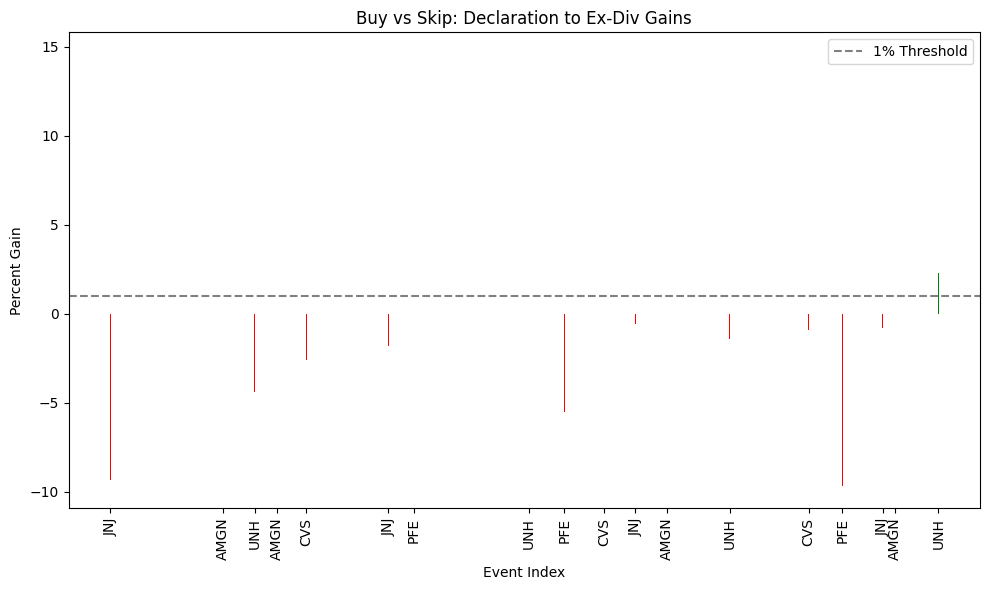


Number of events classified as Buy vs Skip:
Decision
Skip    15
Buy      3
Name: count, dtype: int64


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assume df_events is already created, with columns:
#       ['Stock', 'Date', 'ExDiv_Date', 'Close_Declaration', 'Close_ExDiv', ...]
#     and you want to analyze the % gain from Close_Declaration to Close_ExDiv.

# Step 1: Compute the percentage gain.
df_events['pct_gain'] = (
    (df_events['Close_Ex-Div'] - df_events['Close_Dividends'])
    / df_events['Close_Dividends']
    * 100
)

# Step 2: Classify each event based on the 1% threshold.
df_events['Decision'] = np.where(df_events['pct_gain'] > 1, 'Buy', 'Skip')

# Optional: View a summary table.
print(df_events[['stock', 'Date', 'Close_Dividends', 'Close_Ex-Div', 'pct_gain', 'Decision']])

# Step 3: Visualize the results.
# We'll create a bar chart where each bar is an event, the height is % gain,
# and the color indicates Buy (green) vs Skip (red).

fig, ax = plt.subplots(figsize=(10, 6))

# Map "Buy" to green and "Skip" to red for bar colors.
colors = df_events['Decision'].map({'Buy': 'green', 'Skip': 'red'})

# Plot a bar for each event in df_events.
ax.bar(df_events.index, df_events['pct_gain'], color=colors)

# Draw a horizontal line at y=1 to indicate the 1% threshold.
ax.axhline(1, color='gray', linestyle='--', label='1% Threshold')

# Optional: Label the x-axis by Stock (if you want each bar labeled).
# If you have many events, consider rotating or skipping labels.
ax.set_xticks(df_events.index)
ax.set_xticklabels(df_events['stock'], rotation=90)

ax.set_xlabel('Event Index')
ax.set_ylabel('Percent Gain')
ax.set_title('Buy vs Skip: Declaration to Ex-Div Gains')
ax.legend()
plt.tight_layout()
plt.show()

# (Optional) You might also want to see how many "Buy" vs "Skip" events there are:
decision_counts = df_events['Decision'].value_counts()
print("\nNumber of events classified as Buy vs Skip:")
print(decision_counts)


In [11]:
import pandas as pd
import numpy as np

# Suppose df_events already has 'pct_gain' computed.
# Create a binary label column
df_events['label'] = np.where(df_events['pct_gain'] > 1, 1, 0)


In [12]:
# Columns we *cannot* use because they won’t be known on announcement day:
# 'Close_ExDiv', 'pct_gain', 'label', 'ExDiv_Date', etc.
exclude_cols = [
    'Close_Ex-Div',
    'pct_gain',
    'label',
    'Ex-Div_Date',
    'Dividends',
    'Ex-Div'  # if that indicates future knowledge
]

# If you still need to drop 'Date' (the future date is known, but it might not be predictive).
# That depends on your approach; you can keep it if you want to do time-based features.
exclude_cols.append('Date')

# Create feature matrix X and label vector y
feature_cols = [col for col in df_events.columns if col not in exclude_cols]
X = df_events[feature_cols].copy()
y = df_events['label']


In [13]:
if 'Stock' in X.columns:
    X = pd.get_dummies(X, columns=['Stock'], prefix='Stock')


In [18]:
# ----- Step 4: Prepare Features, Convert Date Columns, Train Classifier -----

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 1. (Optional) Create a numeric label if you haven't done so:
#    e.g. df_events['label'] = np.where(df_events['pct_gain'] > 1, 1, 0)

# 2. Convert the 'Date' column (if present) to a numeric format (ordinal).
#    This allows the model to use date info if you wish.
#    If you prefer to exclude date info entirely, skip this step.
if 'Date' in df_events.columns:
    df_events['Date_ordinal'] = df_events['Date'].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)

# 3. Identify columns to exclude because they are:
#    - labels or outcomes (pct_gain, label, Decision, etc.)
#    - future data (Close_ExDiv, ExDiv_Date, etc.)
#    - raw datetime columns (Date), if you've created a numeric replacement
exclude_cols = [
    'pct_gain',       # final outcome
    'Close_Ex-Div',    # future data
    'Ex-Div_Date',     # future data
    'Dividends',       # future info
    'Ex-Div',          # future info
    'Decision',       # string label, if it exists
    'label',          # numeric label
    'Date'            # raw datetime (now replaced by Date_ordinal)
]

# 4. Build the feature matrix (X).
feature_cols = [col for col in df_events.columns if col not in exclude_cols]
X = df_events[feature_cols].copy()

# 5. Build the label vector (y).
#    Ensure 'label' is a column with 1 = "Buy" / 0 = "Skip".
y = df_events['label']

# 6. Convert any remaining categorical columns to numeric.
#    For example, one‑hot encode 'Stock' if it still exists in X.
if 'stock' in X.columns:
    X = pd.get_dummies(X, columns=['stock'], prefix='stock')

# 7. At this point, X should be fully numeric (float/int). Check for any object dtypes:
# print(X.dtypes)

# 8. Split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# 9. Train a classification model (e.g. Random Forest).
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 10. Evaluate performance on the test set.
y_pred = clf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[3 0]
 [1 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


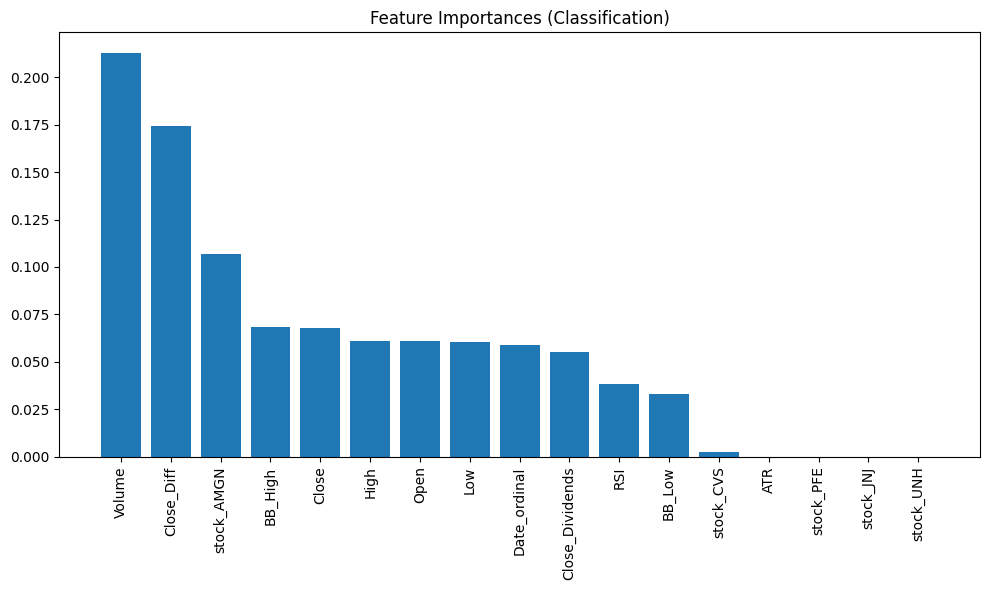

In [19]:
# ----- Step 5: Feature Importance Visualization -----

import matplotlib.pyplot as plt

# RandomForestClassifier provides a 'feature_importances_' attribute.
importances = clf.feature_importances_
indices = importances.argsort()[::-1]  # sort descending
features_sorted = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Classification)")
plt.bar(range(len(features_sorted)), importances[indices], align="center")
plt.xticks(range(len(features_sorted)), features_sorted, rotation=90)
plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[3 0]
 [1 0]]


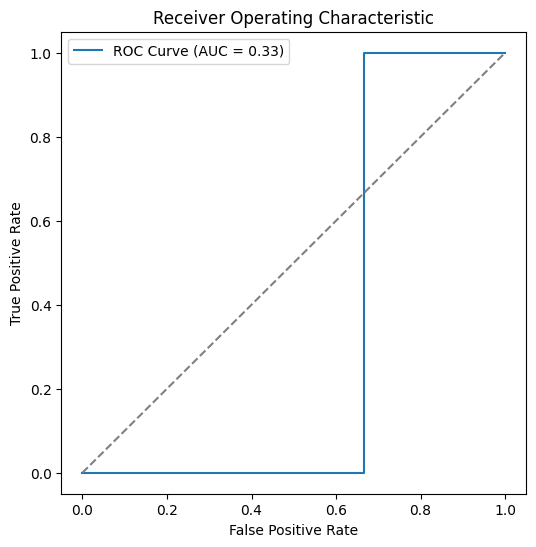

In [22]:
from sklearn.metrics import roc_curve, auc

y_scores = clf.predict_proba(X_test)[:, 1]  # Probability for class=1 ("Buy")
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


In [23]:
def predict_new_announcement(new_data):
    """
    Predict whether a new announcement event is a "Buy" (over 1% gain) or "Skip" (1% gain or less).

    Parameters:
      new_data (pd.DataFrame): DataFrame containing new announcement events with the same features as used in training.
                               It should include only features known at the announcement date, such as:
                               - 'Close_Dividends'
                               - 'Volume'
                               - 'ATR'
                               - 'Date' (if available; will be converted to numeric)
                               - 'Stock'
                               ... and any other relevant features.

    Returns:
      A tuple (predictions, pred_proba):
         - predictions: a list of strings ("Buy" or "Skip")
         - pred_proba: an array with the class probabilities for each event
    """
    new_data = new_data.copy()

    # If a Date column exists, convert it to a numeric value (ordinal)
    if 'Date' in new_data.columns:
        new_data['Date_ordinal'] = new_data['Date'].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
        # Drop the raw Date column since we've replaced it
        new_data.drop(columns=['Date'], inplace=True)

    # One-hot encode the 'Stock' column if it exists.
    if 'stock' in new_data.columns:
        new_data = pd.get_dummies(new_data, columns=['stock'], prefix='stock')

    # Align new_data's columns with the training features.
    # X.columns comes from the features we built in Step 4.
    new_data = new_data.reindex(columns=X.columns, fill_value=0)

    # Predict using the trained classifier.
    pred = clf.predict(new_data)
    pred_proba = clf.predict_proba(new_data)

    # Map numeric predictions to decision labels.
    decision_map = {1: "Buy", 0: "Skip"}
    predictions = [decision_map[label] for label in pred]

    return predictions, pred_proba

# ----- Example Usage -----
# Create a sample new announcement event. Adjust the feature values as needed.
new_event = pd.DataFrame({
    'Close_Dividends': [150.25],
    'Volume': [1200000],
    'ATR': [2.5],
    'Date': [pd.Timestamp("2023-11-01")],
    'Stock': ["AMGN"],
    # Include any other features that were used in training
})

predictions, probabilities = predict_new_announcement(new_event)
print("Predicted Decision:", predictions)
print("Prediction Probabilities:", probabilities)


Predicted Decision: ['Skip']
Prediction Probabilities: [[0.75 0.25]]


In [29]:
import pandas as pd

new_event = pd.DataFrame({
    "Close_Dividends": [78.27],
    "Volume": [8800000],
    "ATR": [1.34],
    "Date": [pd.Timestamp("2024-03-21")],  # explicit Timestamp
    "stock": ["CVS"]
})

predictions, probabilities = predict_new_announcement(new_event)
print("Predicted Decision:", predictions)
print("Prediction Probabilities:", probabilities)


Predicted Decision: ['Skip']
Prediction Probabilities: [[0.94 0.06]]
